# Rayleigh-Benard Convection

Within the present task it is necessary to solve a Navier-Stokes equations (NSE) to  describe the transport of an incompressible fluid. The non-dimensional NSE consist of:

- Mass conservation equation:  

$$
\frac{\partial \~u}{\partial \~x} + \frac{\partial \~v}{\partial \~y}  = 0
$$

- Momentum conservation equations

$$\frac{\partial \tilde{u}}{\partial \tilde{t}} + \tilde{u} \frac{\partial \tilde{u}}{\partial \tilde{x}} + \tilde{v} \frac{\partial \tilde{u}}{\partial \tilde{y}} = -\frac{\partial \tilde{p}}{\partial \tilde{x}} + \frac{1}{Re} \left( \frac{\partial^2 \tilde{u}}{\partial \tilde{x}^2} + \frac{\partial^2 \tilde{u}}{\partial \tilde{y}^2} \right)$$

$$\frac{\partial \tilde{v}}{\partial \tilde{t}} + \tilde{u} \frac{\partial \tilde{v}}{\partial \tilde{x}} + \tilde{v} \frac{\partial \tilde{v}}{\partial \tilde{y}} = -\frac{\partial \tilde{p}}{\partial \tilde{y}} + \frac{1}{Re} \left( \frac{\partial^2 \tilde{v}}{\partial \tilde{x}^2} + \frac{\partial^2 \tilde{v}}{\partial \tilde{y}^2} \right) + \tilde{\rho}g$$

Where:

- $\tilde{x}$ is the non-dimensional space component.

- $\tilde{t}$ is the non-dimensional time.

- $\tilde{u}, \tilde{v}$ are the horizontal and vertical components of the non-dimensional velocity vector.

- $\tilde{p}$ is the non-dimensional pressure.

- $Re$ is the Reynolds number, defined as $Re = u_{ref}x_{ref} / \nu$, where $u_{ref}$ is the reference velocity, $x_{ref}$ is the reference length scale, and $\nu$ is the kinematic viscosity of the fluid.

- $\tilde{\rho}$ is the non-dimensional density of the fluid, the value of which is governed by the following scalar transport equation: The evolution of the non-dimensional density (or temperature scalar) is governed by:

$$\frac{\partial \tilde{\rho}}{\partial \tilde{t}} + \tilde{u} \frac{\partial \tilde{\rho}}{\partial \tilde{x}} + \tilde{v} \frac{\partial \tilde{\rho}}{\partial \tilde{y}} = \frac{1}{Pe} \left( \frac{\partial^2 \tilde{\rho}}{\partial \tilde{x}^2} + \frac{\partial^2 \tilde{\rho}}{\partial \tilde{y}^2} \right)$$

Where:

- $Pe$ is the Peclet number, defined as $Pe = u_{ref}x_{ref} / D$.
- $D$ corresponds to the diffusion coefficient.

Scenario: Solve the NSE for a heated lower wall below a cold top wall together with the  convection-diffusion equation for non-dimensional density using the SIMPLE algorithm  within a 2D-squared domain, where $L_X = L_Y = 1[cm]$, the kinematic viscosity of the fluid  $v = 10^{-6}[m^2/s]$ and the diffusion coefficient $D = 10^{-8}[m^2/s]$. 

Boundary conditions. For velocity and pressure fields the boundary conditions are no-slip walls  (i.e. zero values of velocity and zero gradient for pressure). For non-dimensional density: top  wall $\rho  = 1$, bottom wall $\rho  = 0$, and periodic BC for side walls.   

Initial conditions. Pressure and velocity are initialized with zero values. Non-dimensional  density initialized with values $\rho  = 0$.  

In [ ]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from typing import Dict, Tuple
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve

1. Grid Generation (Staggered Grid)
In a staggered grid, we don't just have one set of coordinates. We define separate locations for the cell centers (Scalars) and the cell faces (Velocities).

In [ ]:
# Parameters from documentation
L = 1  # 1 cm
Nx, Ny = 100, 0
dx, dy = L/Nx, L/Ny
dt = 0.001
Pe = 100 # Peclet number just for example


2. Matrix Assembly Logic

For each variable, we flatten the 2D grid into a 1D vector of size $N = N_x \times N_y$. The mapping is usually $k = i + j \cdot N_x$.A. Periodic Boundary Conditions (Mapping)Since the side walls are periodic, the "West" neighbor of the first column ($i=0$) is the last column ($i=Nx-1$).

In [24]:
def get_k(i, j):
    """Maps 2D indices to 1D with periodic X-boundaries."""
    return (i % Nx) + j * Nx

3. Step-by-Step Numerical Implementation

Step 1: Solve for Density ($\tilde{\rho}$)

We solve $A_\rho \rho = b_\rho$. The matrix $A_\rho$ is constructed using the current velocity field.

1. Discretization of the Scalar Transport Equation

The non-dimensional scalar transport equation governing the density evolution is given by:

$$\frac{\partial \tilde{\rho}}{\partial \tilde{t}} + \tilde{u} \frac{\partial \tilde{\rho}}{\partial \tilde{x}} + \tilde{v} \frac{\partial \tilde{\rho}}{\partial \tilde{y}} = \frac{1}{Pe} \left( \frac{\partial^2 \tilde{\rho}}{\partial \tilde{x}^2} + \frac{\partial^2 \tilde{\rho}}{\partial \tilde{y}^2} \right)$$

To solve this numerically, we apply an implicit Backward Euler scheme in time and Central Difference schemes for spatial derivatives. The discretized equation at node $(i,j)$ for the next time step $k+1$ is:

$$\frac{\rho_{i,j}^{k+1} - \rho_{i,j}^k}{\Delta t} + u_{i,j} \frac{\rho_{i+1,j}^{k+1} - \rho_{i-1,j}^{k+1}}{2\Delta x} + v_{i,j} \frac{\rho_{i,j+1}^{k+1} - \rho_{i,j-1}^{k+1}}{2\Delta y} = \frac{1}{Pe} \left( \frac{\rho_{i+1,j}^{k+1} - 2\rho_{i,j}^{k+1} + \rho_{i-1,j}^{k+1}}{\Delta x^2} + \frac{\rho_{i,j+1}^{k+1} - 2\rho_{i,j}^{k+1} + \rho_{i,j-1}^{k+1}}{\Delta y^2} \right)$$

We adopt the compass notation for the grid stencil, where the central node $(i,j)$ is denoted as $P$, and its neighbors as $E$ (East, $i+1$), $W$ (West, $i-1$), $N$ (North, $j+1$), and $S$ (South, $j-1$).By grouping terms associated with the unknown time step $k+1$ on the left-hand side, we obtain the following linear algebraic equation:

$$A_p \rho_p^{k+1} + A_e \rho_e^{k+1} + A_w \rho_w^{k+1} + A_n \rho_n^{k+1} + A_s \rho_s^{k+1} = \rho_p^k$$

Where the coefficients are defined as:

$$\begin{aligned}
A_e &= C_x - D_x \\
A_w &= -C_x - D_x \\
A_n &= C_y - D_y \\
A_s &= -C_y - D_y \\
A_p &= 1 + 2D_x + 2D_y
\end{aligned}$$

The non-dimensional advection ($C$) and diffusion ($D$) numbers are defined as:

$$C_x = \frac{u \Delta t}{2\Delta x}, \quad C_y = \frac{v \Delta t}{2\Delta y}, \quad D_x = \frac{\Delta t}{Pe \Delta x^2}, \quad D_y = \frac{\Delta t}{Pe \Delta y^2}$$

In [25]:
def solve_rho(u: np.ndarray, v: np.ndarray, rho_n: np.ndarray, Pe: float, dt: float):
    N = Nx * Ny
    A = lil_matrix((Nx*Ny, Nx*Ny)) # Sparse matrix in LIL format for assembly
    b = np.zeros(Nx*Ny)
    
    # velocity components
    u = u
    v = v

    u_center = 0.5 * (u[:, 0:-1] + u[:, 1:]) 
    v_center = 0.5 * (v[0:-1, :] + v[1:, :])

    b = np.zeros(N)

    # Diffusion coefficient
    Dx  = dt / (Pe * dx**2) 
    Dy  = dt / (Pe * dy**2) 
    

    for j in range(Ny):
        for i in range(Nx):

            # Stablish boundary conditions for Density: Top=1, Bottom=0
            idx = get_k(i, j) # Current node index and current row in matrix A
            
            # Bottom Wall (j=0): Fixed Value rho = 0
            if j == 0:
                A[idx, idx] = 1.0
                b[idx] = 0.0
                continue
                
            # Top Wall (j=Ny-1): Fixed Value rho = 1
            if j == Ny - 1:
                A[idx, idx] = 1.0
                b[idx] = 1.0
                continue


            # Local velocities
            u_val = u_center[j, i]
            v_val = v_center[j, i]

            # Advection Coefficient
            Cx = (u_val * dt) / (2 * dx)
            Cy = (v_val * dt) / (2 * dy)
            
            # Coefficients (Central Difference)
            ae = Cx - Dx
            aw = -Cx - Dx

            an = Cy - Dy
            as_ = -Cy - Dy

            ap = (1) + (2*Dx + 2*Dy)
            
            
            # Neighbors (Periodic in X)
            idx_p = idx
            idx_e = get_k(i+1, j)
            idx_w = get_k(i-1, j)
            idx_n = get_k(i, j+1)
            idx_s = get_k(i, j-1)

            # Matrix Assembly

            A[idx_p, idx_p] = ap
            A[idx_p, idx_e] = ae
            A[idx_p, idx_w] = aw
            A[idx_p, idx_n] = an
            A[idx_p, idx_s] = as_

            # Right-hand side
            b[idx_p] = rho_n[j, i]
    rho_matrix = A.tocsr()  # Convert to CSR format for efficient solving
    rho_solved = spsolve(rho_matrix, b)
    return rho_solved.reshape((Ny, Nx))



### 2. Discretization of the Momentum Equations

The non-dimensional Navier-Stokes momentum equations are:

$$\frac{\partial \tilde{u}}{\partial \tilde{t}} + \tilde{u} \frac{\partial \tilde{u}}{\partial \tilde{x}} + \tilde{v} \frac{\partial \tilde{u}}{\partial \tilde{y}} = -\frac{\partial \tilde{p}}{\partial \tilde{x}} + \frac{1}{Re} \left( \frac{\partial^2 \tilde{u}}{\partial \tilde{x}^2} + \frac{\partial^2 \tilde{u}}{\partial \tilde{y}^2} \right)$$

$$\frac{\partial \tilde{v}}{\partial \tilde{t}} + \tilde{u} \frac{\partial \tilde{v}}{\partial \tilde{x}} + \tilde{v} \frac{\partial \tilde{v}}{\partial \tilde{y}} = -\frac{\partial \tilde{p}}{\partial \tilde{y}} + \frac{1}{Re} \left( \frac{\partial^2 \tilde{v}}{\partial \tilde{x}^2} + \frac{\partial^2 \tilde{v}}{\partial \tilde{y}^2} \right) + \tilde{\rho}g$$

These equations are solved on a staggered grid. The velocity components $u$ and $v$ are stored at the cell faces, while pressure and density are stored at the cell centers. Using the Momentum Predictor step of the SIMPLE algorithm, we solve for intermediate velocities ($U^*, V^*$) using the pressure field from the previous iteration.

The discretized algebraic equations are:

**U-Momentum Predictor:**

$$U_p^* \underbrace{(1 + 2D_x + 2D_y)}_{A_p} + U_e^* \underbrace{(C_x - D_x)}_{A_e} + U_w^* \underbrace{(-C_x - D_x)}_{A_w} + U_n^* \underbrace{(C_y - D_y)}_{A_n} + U_s^* \underbrace{(-C_y - D_y)}_{A_s} = \underbrace{U_p^0 - \frac{\Delta t}{\Delta x}(P_e - P_w)}_{b}$$

**V-Momentum Predictor:**

$$V_p^* \underbrace{(1 + 2D_x + 2D_y)}_{A_p} + V_e^* \underbrace{(C_x - D_x)}_{A_e} + V_w^* \underbrace{(-C_x - D_x)}_{A_w} + V_n^* \underbrace{(C_y - D_y)}_{A_n} + V_s^* \underbrace{(-C_y - D_y)}_{A_s} = \underbrace{V_p^0 - \frac{\Delta t}{\Delta y}(P_n - P_s) + \Delta t \rho g}_{b}$$

The coefficients for the momentum equations are defined as follows:

$$C_x = \frac{u \Delta t}{2 \Delta x}, \quad C_y = \frac{v \Delta t}{2 \Delta y}$$

$$D_x = \frac{\Delta t}{Re \Delta x^2}, \quad D_y = \frac{\Delta t}{Re \Delta y^2}$$

For the U-momentum equation, the pressure term uses the gradient across the vertical faces ($\Delta x$), while the V-momentum equation uses the gradient across the horizontal faces ($\Delta y$) and includes the gravity term.

In [29]:

u0 = np.zeros((Ny, Nx + 1))  # u-velocity at vertical faces
v0 = np.zeros((Ny + 1, Nx))  # v-velocity at horizontal faces
rho_0 = np.zeros((Ny, Nx))  # Initial density field

def solve_u_velocities(u, v, p, rho, dt, Re):
  Nu = Ny * (Nx - 1) # since we're going for the faces of the grid

  AU = lil_matrix((Nu, Nu)) # Sparse matrix in LIL format for assembly

  bu = np.zeros(Nu) 

  # Diffusion coefficients
  Dx_u  = dt / (Re * dx**2)
  Dy_u  = dt / (Re * dy**2)

  def get_row_idx(i, j):
    # Map to the interior of the u-velocity grid
    return (i- 1) + j * (Nx - 1) # the i - 1 since in the matrix we're not counting the first vertical face
  

  for j in range(Ny):
    for i in range(1, Nx):  # u-velocity at vertical faces

      row = get_row_idx(i, j) 

      grad_p = (p[j, i] - p[j, i-1]) / dx
      bu[row] = u[j, i] - (dt * grad_p)

      # u_p: Velocity at this face (from previous step)
      u_p = u[j, i]

      # --- V-Averaging with Boundary Safety ---
      # We need v at the corners (i, j), (i, j+1), (i-1, j), (i-1, j+1)
      # v array shape: (Ny+1, Nx)
      v_S_R = v[j, i]       # South-Right
      v_S_L = v[j, i-1]     # South-Left
      v_N_R = v[j+1, i]     # North-Right
      v_N_L = v[j+1, i-1]   # North-Left

      v_avg = 0.25 * (v_S_R + v_S_L + v_N_R + v_N_L)


      # Advection Coefficients
      Cx = (u_p * dt) / (2 * dx)
      Cy = (v_avg * dt) / (2 * dy)

      # Matrix coefficients
      ae = Cx - Dx_u
      aw = -Cx - Dx_u
      an = Cy - Dy_u
      as_ = -Cy - Dy_u
      ap = (1) + (2*Dx_u + 2*Dy_u)


      # Matrix assembly
      AU[row, row] = ap

      # get neighbor indices
      idx_e = get_row_idx(i+1, j)
      idx_w = get_row_idx(i-1, j)
      idx_n = get_row_idx(i, j+1)
      idx_s = get_row_idx(i, j-1)

      if i + 1 < Nx: # Right neighbor exists
        AU[row, idx_e] = ae
      else:
        pass

      if i - 1 >= 1: # Left neighbor exists
        AU[row, idx_w] = aw
      else:
        pass

      if j + 1 < Ny: # North neighbor exists
        AU[row, idx_n] = an
      else:
        bu[row] -= an * 0
      if j - 1 >= 0: # South neighbor exists
        AU[row, idx_s] = as_
      else:
        bu[row] -= as_ * 0



  u_matrix = AU.tocsr()  # Convert to CSR format for efficient solving
  u_solved = spsolve(u_matrix, bu)

  u_interior = u_solved.reshape((Ny, Nx-1))

# 2. Create full array and paste interior
  u_new = np.zeros_like(u) # Zeros handles the walls automatically
  u_new[:, 1:-1] = u_interior

  return u_new


def solve_v_velocities(u, v, p, rho, dt, Re):
  Nv = Nx * (Ny - 1) # since we're going for the faces of the grid

  AV = lil_matrix((Nv, Nv)) # Sparse matrix in LIL format for assembly

  bv = np.zeros(Nv) 

  # Diffusion coefficients
  Dx_v  = dt / (Re * dx**2)
  Dy_v  = dt / (Re * dy**2)

  def get_row_idx(i, j):
    # Map to the interior of the v-velocity grid
    return i + ((j - 1) * Nx) # (Maps $j=1$ to row 0).
  

  for j in range(1, Ny):
    for i in range(Nx):  # v-velocity at vertical faces

      row = get_row_idx(i, j) 

      grad_p = (p[j, i] - p[j-1, i]) / dy
      rho_avg = 0.5 * (rho[j, i] + rho[j-1, i])
      buoyancy = rho_avg * 9.81  # Or your specific 'g' value


      bv[row] = v[j, i] - (dt * grad_p) + (dt * buoyancy)  # Adding buoyancy term

      # v_p: Velocity at this face (from previous step)
      v_p = v[j, i]

      # --- U-Averaging with Boundary Safety ---
      # We need u at the corners (i, j), (i, j+1), (i-1, j), (i-1, j+1)
      # v array shape: (Ny+1, Nx)
      # Current row neighbors (j)
      u_S_R = u[j, i]
      # Check left wall for S_L
      u_S_L = u[j, i-1] if i-1 >= 0 else 0.0
      
      # Top row neighbors (j+1) -> CAREFUL!
      if j+1 < Ny:
          u_N_R = u[j+1, i]
          u_N_L = u[j+1, i-1] if i-1 >= 0 else 0.0
      else:
          # We are at the top edge. The 'u' above us is the Top Wall (No-Slip = 0.0)
          u_N_R = 0.0
          u_N_L = 0.0

      u_avg = 0.25 * (u_S_R + u_S_L + u_N_R + u_N_L)


      # Advection Coefficients
      Cx = (u_avg * dt) / (2 * dx)
      Cy = (v_p * dt) / (2 * dy)

      # Matrix coefficients
      ae = Cx - Dx_v
      aw = -Cx - Dx_v
      an = Cy - Dy_v
      as_ = -Cy - Dy_v
      ap = (1) + (2*Dx_v + 2*Dy_v)


      # Matrix assembly
      AV[row, row] = ap

      # get neighbor indices
      idx_e = get_row_idx(i+1, j)
      idx_w = get_row_idx(i-1, j)
      idx_n = get_row_idx(i, j+1)
      idx_s = get_row_idx(i, j-1)

      if i + 1 < Nx: # Right neighbor exists
        AV[row, idx_e] = ae
      else:
        pass

      if i - 1 >= 0: # Left neighbor exists
        AV[row, idx_w] = aw
      else:
        pass

      if j + 1 < Ny: # North neighbor exists
        AV[row, idx_n] = an
      else:
        bv[row] -= an * 0
      if j - 1 >= 0: # South neighbor exists
        AV[row, idx_s] = as_
      else:
        bv[row] -= as_ * 0


  v_matrix = AV.tocsr()  # Convert to CSR format for efficient solving
  v_solved = spsolve(v_matrix, bv)

  v_interior = v_solved.reshape((Ny- 1, Nx))

# 2. Create full array and paste interior
  v_new = np.zeros_like(v) # Zeros handles the walls automatically
  v_new[1:-1, :] = v_interior

  return v_new



Following the calculation of the intermediate velocity fields ($u^*, v^*$), a correction step is necessary because these predicted solutions do not satisfy the mass conservation equation (continuity):

$$
\frac{\partial \~u}{\partial \~x} + \frac{\partial \~v}{\partial \~y}  = 0
$$

Also written as

$$
\nabla \cdot \vec{u}  = 0
$$

This implies that the divergence of the velocity field must be zero, meaning that the net outflow of the cells is not generating or destroying mass.In the SIMPLE algorithm, we calculate the divergence of the Predicted Velocities ($u^*, v^*$). This value tells us the "mass error" in that cell.

- If $b > 0$: The cell has too much outflow. We need to lower pressure to suck fluid back in.
- If $b < 0$: The cell has net inflow. We need to raise pressure to push fluid out.

For the staggered grid, where velocities are defined at the cell faces, the discrete mass imbalance (source term $b$) at cell $(i,j)$ is:

$$b_{i,j} = - \left( \frac{u^*_{i+1, j} - u^*_{i, j}}{\Delta x} + \frac{v^*_{i, j+1} - v^*_{i, j}}{\Delta y} \right)$$

To correct this error, we solve the Pressure Poisson Equation (PPE) for a correction field $p'$:

$$\nabla^2 p' = \frac{\rho}{\Delta t} (\nabla \cdot \vec{u}^*)$$

This enforces the divergence-free condition for velocity by relating the Laplacian of pressure to the divergence of velocity. The required Pressure Correction ($p'$) is such that if we nudge the velocities by the gradient of $p'$, the new divergence becomes (approximately) zero.

The correction formula is derived from the momentum equation. By writing the semi-discretized momentum equations for both the predicted velocity ($u^*$) and the corrected velocity ($u^{new}$):

$$\frac{u^* - u^n}{\Delta t} = \text{Advection} + \text{Diffusion} - \frac{\partial p^n}{\partial x}$$

$$\frac{u^{new} - u^n}{\Delta t} = \text{Advection} + \text{Diffusion} - \frac{\partial p^{new}}{\partial x}$$

Subtracting the first equation from the second, the $u^n$, Advection, and Diffusion terms cancel out (assuming they do not change significantly during the correction step). We obtain:

$$\frac{u^{new} - u^*}{\Delta t} = - \left( \frac{\partial p^{new}}{\partial x} - \frac{\partial p^n}{\partial x} \right) = = - \frac{\partial p'}{\partial x}$$

Rearranging and discretizing this yields the formulas to update the velocity fields:

$$u^{new}_{i,j} = u^*_{i,j} - \Delta t \frac{p'_{i,j} - p'_{i-1,j}}{\Delta x}$$

$$v^{new}_{i,j} = v^*_{i,j} - \Delta t \frac{p'_{i,j} - p'_{i,j-1}}{\Delta y}$$

## Derivation of the Discrete Poisson Equation

To find the matrix coefficients, we enforce the continuity constraint on the new velocities. For a cell centered at $P$, mass conservation requires: 

$$\nabla^2 p' = \frac{\rho}{\Delta t} (\nabla \cdot \vec{u}^*)$$

$$\frac{u^{new}_{e} - u^{new}_{w}}{\Delta x} + \frac{v^{new}_{n} - v^{new}_{s}}{\Delta y} = 0$$

where $e, w, n, s$ denote the East ($i+1$), West ($i$), North ($j+1$), and South ($j$) faces of the cell.

Substituting the velocity correction formulas into this continuity equation:

$$\frac{\left[ u^*_{e} - \frac{\Delta t}{\Delta x}(p'_E - p'_P) \right] - \left[ u^*_{w} - \frac{\Delta t}{\Delta x}(p'_P - p'_W) \right]}{\Delta x} + \frac{\left[ v^*_{n} - \frac{\Delta t}{\Delta y}(p'_N - p'_P) \right] - \left[ v^*_{s} - \frac{\Delta t}{\Delta y}(p'_P - p'_S) \right]}{\Delta y} = 0$$

We now separate the known terms ($u^*, v^*$) from the unknown terms ($p'$). Moving the velocities to the right-hand side, we get:

$$\underbrace{\frac{-\frac{\Delta t}{\Delta x}(p'_E - p'_P) + \frac{\Delta t}{\Delta x}(p'_P - p'_W)}{\Delta x} + \frac{-\frac{\Delta t}{\Delta y}(p'_N - p'_P) + \frac{\Delta t}{\Delta y}(p'_P - p'_S)}{\Delta y}}_{\text{Pressure Corrections}} = \underbrace{- \left( \frac{u^*_e - u^*_w}{\Delta x} + \frac{v^*_n - v^*_s}{\Delta y} \right)}_{\text{Source Term } b}$$

Expanding the fractions on the left side reveals the coefficients for each pressure node:

$$\left[ \frac{\Delta t}{\Delta x^2} p'_P + \frac{\Delta t}{\Delta x^2} p'_P + \frac{\Delta t}{\Delta y^2} p'_P + \frac{\Delta t}{\Delta y^2} p'_P \right] - \frac{\Delta t}{\Delta x^2} p'_E - \frac{\Delta t}{\Delta x^2} p'_W - \frac{\Delta t}{\Delta y^2} p'_N - \frac{\Delta t}{\Delta y^2} p'_S = b$$

This leads to the final discretized form:

$$A_P p'_P + A_E p'_E + A_W p'_W + A_N p'_N + A_S p'_S = b$$

Where the coefficients correspond to the geometric terms derived above:

$$A_E = -\frac{\Delta t}{\Delta x^2}, \quad A_W = -\frac{\Delta t}{\Delta x^2}$$

$$A_N = -\frac{\Delta t}{\Delta y^2}, \quad A_S = -\frac{\Delta t}{\Delta y^2}$$

$$A_P = \frac{2\Delta t}{\Delta x^2} + \frac{2\Delta t}{\Delta y^2}$$

(Note: In the code implementation, we often multiply the entire equation by -1 to make the diagonal $A_P$ negative and neighbors positive, or move neighbors to the LHS as done here).

Since the system can be written as a matrix system $Ax = b$, the mapping is:$\mathbf{x}$ is the unknown pressure correction $p'$.$A$ is the Laplacian Operator ($\nabla^2$).$\mathbf{b}$ is the Source Term (Divergence).

The Laplacian Operator term ($\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}$) is thus approximated by the stencil:$$\nabla^2 p \approx \frac{p_E - 2p_P + p_W}{\Delta x^2} + \frac{p_N - 2p_P + p_S}{\Delta y^2}$$




In [27]:
def solve_pressure_correction(u_star, v_star, dt, dx, dy):
    """
    Solves Laplacian(p_corr) = RHS
    RHS = -Divergence(u_star, v_star) / dt
    """
    N = Nx * Ny
    A = lil_matrix((N, N))
    b = np.zeros(N)

    
    # Base coefficients
    Ae = dt / dx**2
    Aw = dt / dx**2
    An = dt / dy**2
    As = dt / dy**2

    # The center coefficient should be the sum of the neighbors, meaning that it losses the A neighbor when there is a wall
    Ap = -(Ae + Aw + An + As) 

    for j in range(Ny):
      for i in range(Nx):
        row = get_k(i, j)

        div_u = (u_star[j, i+1] - u_star[j, i]) / dx
        div_v = (v_star[j+1, i] - v_star[j, i]) / dy

        b[row] = - ( div_u + div_v )

        A[row, row] = Ap

        # Note, for pressure the boundary condition is Neumann (dp/dn = 0)

        if i + 1 < Nx: # Right neighbor exists
           idx_e = get_k(i+1, j)
           A[row, idx_e] = Ae
        else:
           A[row, row] += Ae

        if i - 1 >= 0: # Left neighbor exists
           idx_w = get_k(i-1, j)
           A[row, idx_w] = Aw
        else:
           A[row, row] += Aw

        if j + 1 < Ny: # North neighbor exists:
           idx_n = get_k(i, j+1)
           A[row, idx_n] = An
        else:
           A[row, row] += An

        if j - 1 >= 0: # South neighbor exists:
           idx_s = get_k(i, j-1)
           A[row, idx_s] = As
        else:
           A[row, row] += As

    # Since all boundaries are Neumann (gradients), the matrix is singular.
    # We must fix ONE point (e.g., bottom-left) to 0.
    ref_idx = get_k(0, 0)
    A[ref_idx, :] = 0.0     # Clear the row
    A[ref_idx, ref_idx] = 1.0 
    b[ref_idx] = 0.0

    p_corr_matrix = A.tocsr()  # Convert to CSR format for efficient solving
    p_corr_solved = spsolve(p_corr_matrix, b)

    return p_corr_solved.reshape((Ny, Nx))



def apply_corrections(u_star, v_star, p_old, p_corr, dt, dx, dy, Nx, Ny):
    """
    Updates velocity and pressure fields using p_corr.
    u_new = u_star - dt * grad(p_corr)
    """
    alpha = 1.0  # Under-relaxation factor for pressure update
    p_new = p_old + (p_corr * alpha)

    u_new = u_star.copy()
    v_new = v_star.copy()

    for j in range(Ny):
        for i in range(1, Nx):
            u_new[j, i] = u_star[j, i] - dt * (p_corr[j, i] - p_corr[j, i-1]) / dx
    
    for j in range(1, Ny):
        for i in range(Nx):
            v_new[j, i] = v_star[j, i] - dt * (p_corr[j, i] - p_corr[j-1, i]) / dy


    return u_new, v_new, p_new

Starting simulation with 10 steps...
Step 0/10 completed


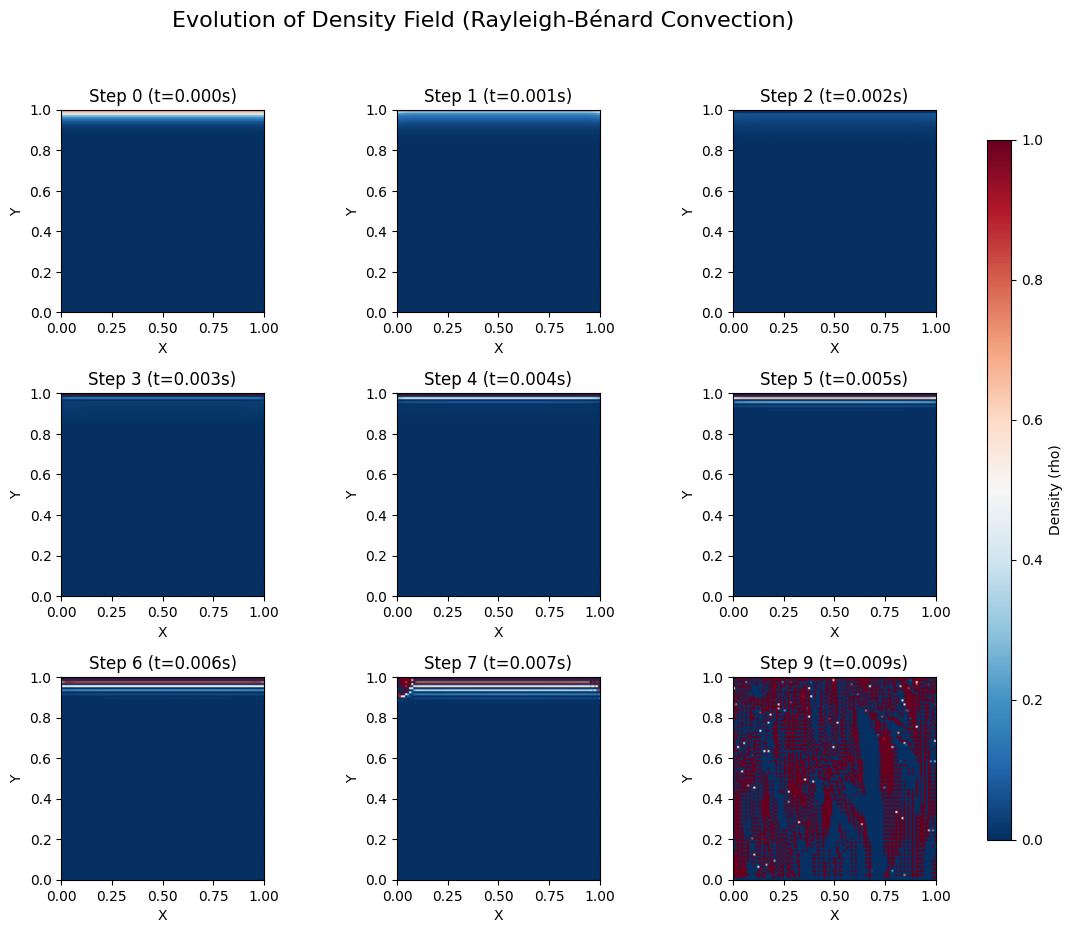

In [35]:
def rayleigh_benard_convection(dt, T, Re, Pe, Nx, Ny, dx, dy):
    # Initialization
    u = np.zeros((Ny, Nx + 1))  # u-velocity
    v = np.zeros((Ny + 1, Nx))  # v-velocity
    
    # TIP: Adding small noise to rho speeds up the onset of instability
    rho = np.zeros((Ny, Nx)) 
    
    p = np.zeros((Ny, Nx))      # Pressure
    
    # Storage for history
    rho_serie = []
    
    num_steps = int(T / dt)

    print(f"Starting simulation with {num_steps} steps...")

    for step in range(num_steps):
        # 1. Solve Density (Scalar Transport)
        rho = solve_rho(u, v, rho, Pe, dt)

        # 2. Predict Velocities (Momentum)
        u_star = solve_u_velocities(u, v, p, rho, dt, Re)
        v_star = solve_v_velocities(u, v, p, rho, dt, Re)

        # 3. Solve Pressure Correction (Poisson)
        # Note: We pass Nx, Ny here as per our previous fix
        p_corr = solve_pressure_correction(u_star, v_star, dt, dx, dy)

        # 4. Correct Fields (Continuity)
        u, v, p = apply_corrections(u_star, v_star, p, p_corr, dt, dx, dy, Nx, Ny)

        # Store a copy of the field
        rho_serie.append(rho.copy())
        
        if step % 50 == 0:
            print(f"Step {step}/{num_steps} completed")

    return rho_serie

# graph results 

import matplotlib.pyplot as plt

# --- 1. Run the Model ---
# Adjust T (Total time) if you want to see further evolution
# Ensure your Re and Pe numbers allow for convection (e.g., Re=1000, Pe=100)
rho_history = rayleigh_benard_convection(dt=0.1, T=1.0, Re=1000.0, Pe=200.0, 
                                         Nx=Nx, Ny=Ny, dx=dx, dy=dy)

# --- 2. Setup the 3x3 Grid ---
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
fig.suptitle('Evolution of Density Field (Rayleigh-Bénard Convection)', fontsize=16)

# Calculate indices for 9 evenly spaced time steps
total_frames = len(rho_history)
indices = np.linspace(0, total_frames - 1, 9, dtype=int)

# --- 3. Plotting Loop ---
for i, ax in enumerate(axes.flat):
    # Get the specific time step index
    idx = indices[i]
    
    # Extract the density field
    field = rho_history[idx]
    
    # Plot using imshow
    # origin='lower' puts (0,0) at bottom-left
    im = ax.imshow(field, origin='lower', cmap='RdBu_r', 
                   extent=[0, Nx*dx, 0, Ny*dy], vmin=0, vmax=1)
    
    ax.set_title(f"Step {idx} (t={idx*0.001:.3f}s)")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

# Add a shared colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, label='Density (rho)')

plt.subplots_adjust(wspace=0.3, hspace=0.4, right=0.9)
plt.show()

### The Implicit Derivation of the Pressure Poisson Equation

It is critical to understand that the Pressure Poisson Equation (PPE) is not an arbitrary formula introduced from outside the Navier-Stokes system. Rather, it is the direct mathematical consequence of enforcing two fundamental physical laws simultaneously:

1. **Momentum (Velocity follows Pressure Gradients):**
From the momentum equation, we know that the correction to velocity depends on the gradient of the pressure correction:



Mathematically, this states that the change in velocity is proportional to the slope of the pressure field.
2. **Continuity (Mass Conservation):**
The corrected velocity field must satisfy the continuity equation, meaning its divergence must be zero:



This ensures that mass is neither created nor destroyed within a cell.

**The Substitution (The "Poisson Moment")**

When we substitute the velocity correction (Law 1) into the continuity constraint (Law 2), we mathematically combine the Divergence and the Gradient operators:

By distributing the divergence operator and rearranging terms (moving the known  to the right-hand side), we isolate the pressure terms:

Or simply:

**The Emergence of the Laplacian**

In vector calculus, the "Divergence of a Gradient" () is defined as the **Laplacian Operator** ().

Thus, the seemingly complex algebraic rearrangement of the discretized terms:

is actually the discrete representation of the Laplacian operator acting on pressure. The left-hand side () represents , and the right-hand side () represents the velocity divergence . Therefore, the matrix system we solve is, by definition, the Poisson equation. We do not "use" it as an extra step; we generate it automatically by enforcing mass conservation on a pressure-driven flow.